<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/02_PyMC_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. PyMC3入門 (1)
* 今回、PyMC3を解説するに当たっては、PyMC3の公式サイトを参考にした。
 * https://docs.pymc.io/notebooks/api_quickstart.html

## 2.0 準備

* arvizはPyMC3用の可視化ツール。

In [1]:
!pip install arviz==0.10
!pip install pymc3==3.10

     |████████████████████████████████| 1.5MB 5.7MB/s 
     |████████████████████████████████| 768kB 16.2MB/s 
     |████████████████████████████████| 4.7MB 22.8MB/s 
     |████████████████████████████████| 317kB 41.2MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
     |████████████████████████████████| 1.9MB 5.8MB/s 
     |████████████████████████████████| 2.8MB 46.6MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.0.11-cp37-none-any.whl size=2572023 sha256=73302e78731e520086b9fef3837b1404d70dab43aada9ba0eca6d5bc8b7dc806
  Stored in directory: /root/.cache/pip/wheels/26/b2/77/4ee2bb9b1c1de7de771254a5e379d898273d8114237b0df686
Successfully built theano-pymc
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


## 2.1 ベイズ的なデータのモデリング

### 2.1.1 ベイズ的モデリングにおけるベイズ則
* 観測データを$X$とする。具体的には同じ次元のベクトルの集まり$X = \{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$である。
* 観測データをモデル化する確率分布のパラメータを$\theta$とする。もちろん、パラメータの個数は複数でありうる。
* 事後分布は、ベイズ則を使うと以下のように書ける。
$$ p(\theta | X) = \frac{ p(X | \theta) p(\theta) }{ p(X) } $$
* ベイズ的モデリングでは、事後分布$p(\theta | X)$を知ることが目標。
 * MCMCは、事後分布から得たサンプルを通して、事後分布の姿を知ろうとする。
 * 変分ベイズ推論は、事後分布を近似する、別の扱いやすい分布を通して、事後分布の姿を知ろうとする。

### 2.1.2 事後分布を知ることはどのくらい難しいか
* 尤度関数$p(X|\theta)$は、我々がデータをモデル化するのに使う分布を固定すれば、式で書ける。
$$ p(X|\theta) = \prod_{i=1}^N p(\mathbf{x}_i | \theta) $$
* 事前分布$p(\theta)$も、どの分布にするかをよく考える必要はあるが、決めてしまえば、式で書ける。
* ということは、$p(X|\theta)$と$p(\theta)$の積も、式で書ける。
$$ p(X|\theta) p(\theta) = p(\theta) \prod_{i=1}^N p(x_i | \theta) $$
* しかし、この積が式で与えられていることと、事前分布を知っていることとの間には、多くの場合、**とてつもなく大きな隔たり**がある。
 * つまり、$p(X|\theta) p(\theta)$を知っていても、決して$p(\theta|X)$を知っていることにはならない。
 * なぜなら、ベイズ則より$p(\theta|X)=\frac{ p(X | \theta) p(\theta) }{ p(X) }$であり、周辺尤度$p(X)$が分かっていないと、$p(\theta|X)$は得られないからである。
 * そして、周辺尤度$p(X)$は、ほとんどの場合、それを計算することが非常に難しいからである。

### 2.1.3 MCMCはベイズ的モデリングだけに使うのではない
* MCMCは、$p(X|\theta) p(\theta)$しか分からないときに、$p(\theta|X)$を推定することを可能にしてくれる。
* しかし、MCMCは、もっと普遍的に適用可能な手法である。
* 普遍性を持たせて言えば、MCMCは、密度関数を規格化する定数が分からないような確率分布について、そこからのサンプリングを可能にしてくれる方法。
 * 密度関数がそれに比例するところの関数が分かれば、MCMCを使って、対応する分布からのサンプルを得ることができる。
 * このようなMCMCを、ベイズ的なモデリングでは、事後分布を知ろうとするために使っているだけ。
$$ P(\theta | X) \propto P(X | \theta) P(\theta)$$

### 2.1.4 確率分布からのサンプリングとは？
* 例えば、区間$[0,1)$上に定義された一様分布からサンプリングすることは、どのぐらい難しいことなのだろうか？
 * 答：全然自明な作業ではない。（cf. [メルセンヌ・ツイスタ](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%83%AB%E3%82%BB%E3%83%B3%E3%83%8C%E3%83%BB%E3%83%84%E3%82%A4%E3%82%B9%E3%82%BF)）
* 一様乱数を発生させる乱数発生器をサブルーチンとして使えば、他の分布からのサンプリングも実装できる。
 * 例：[ボックス＝ミュラー法](https://ja.wikipedia.org/wiki/%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%EF%BC%9D%E3%83%9F%E3%83%A5%E3%83%A9%E3%83%BC%E6%B3%95)
 * 例：[逆関数サンプリング法](https://ja.wikipedia.org/wiki/%E9%80%86%E9%96%A2%E6%95%B0%E6%B3%95)
* MCMCは、特定の分布用に作られたサンプリング法ではなく、様々な確率分布からのサンプリングを可能にする、汎用性のある手法である。

## 2.2 PyMC3でモデルを作る

### 2.2.1 PyMC3における確率変数

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm

%config InlineBackend.figure_format = 'retina'

* PyMC3では、いきなり確率変数を作ることはできない。
 * パラメータが1の指数分布に従う確率変数を作ろうとして、下のセルを（「＃」を外して）実行すると、エラーが出るはず。

In [3]:
# lambda_ = pm.Exponential("poisson_param", 1)

* 確率変数は、いきなり作るのではなく、必ずモデルの中で作る。
 * あらかじめ空のインスタンスを作っておき、「with model:」というブロックを書くか、
 * いきなり「with pm.Model() as model:」というブロックを書くかの、いずれか。

In [4]:
model = pm.Model()
with model:
    lambda_ = pm.Exponential("poisson_param", 1)

In [5]:
with pm.Model() as model:
    lambda_ = pm.Exponential("poisson_param", 1)

* 確率分布が作れたので、いきなりサンプリングしてみることもできる。
 * これは単に指数分布からのサンプリングで、何かの事後分布からのサンプリングでも何でもない。

In [6]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Sequential sampling (2 chains in 1 job)
Metropolis: [poisson_param]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 3 seconds.
The number of effective samples is smaller than 25% for some parameters.


* ヒストグラムが指数分布の密度関数っぽい形かどうかを見てみる。

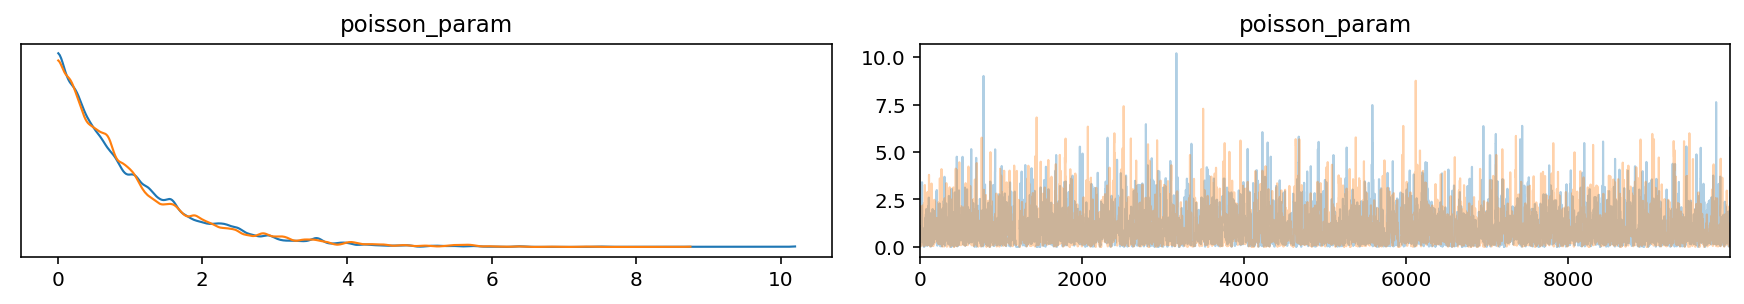

In [7]:
import arviz as az
with model:
    az.plot_trace(trace)

### 2.2.2 観測データのベイズ的なモデリングの例

* データモデルとして用意したベイズ的な確率モデルを、与えられた観測データに当てはめてみる例を、下に示す。
* ベイズ的なモデリングでは、最尤推定やMAP推定のように、モデルのパラメータの値を決め打ちで求めるのではない。
* 観測データ$X$を所与とする、パラメータ$\theta$の条件付き確率分布である、事後分布$P(\theta|X)$を求める。
 * 事後分布を求めようとするパラメータ$\theta$には、事前分布$P(\theta)$を設定する。

* 下のモデルは、まず、平均パラメータが0で標準偏差パラメータが1の正規分布に従うunobservedな確率変数muを持っている。
 * この正規分布は、平均パラメータが従う事前分布。
* そして、平均パラメータが確率変数muで標準偏差パラメータが1の正規分布に従うobservedな確率変数obsを持っている。
 * この正規分布は、データを直接モデリングする確率分布。
* さらに、観測データとして、正規乱数として生成した100個の数値を指定している。

In [8]:
model = pm.Model()
with model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

* いま定義したモデルを数式で書くと・・・
$$ \mu \sim N(0, 1) $$
$$ x \sim N(\mu, 1) $$


* notebook環境でPyMC3を使っているときは、以下のように、確率変数がどんな分布に従うかを簡単に確認できる。

In [9]:
mu

mu ~ Normal

* 確率変数には、その名前を使ってアクセスすることもできる。

In [10]:
model.named_vars["mu"]

mu ~ Normal

In [11]:
obs

obs ~ Normal

In [12]:
model.named_vars["obs"]

obs ~ Normal

* PyMC3の確率変数(RV: random variable)には以下の2種類がある。
cf. https://docs.pymc.io/api/variables.html


1.   Free (= Unobserved) RVs that a model is specified in terms of. 
2.   Observed RVs that a model is specified in terms of. Potentially partially observed.



In [13]:
model.free_RVs

[mu ~ Normal]

In [14]:
model.observed_RVs

[obs ~ Normal]

* `basic_RVs`: List of random variables the model is defined in terms of (which excludes deterministics)
 * deterministicsについては後で説明。

In [15]:
model.basic_RVs

[mu ~ Normal, obs ~ Normal]

### 2.2.2 log probabilityの計算

* 観測データを100個指定しているので、muを特定の値に固定することでlog probabilityを計算することができる。
 * `logp`は、後で見るように、同時分布$p(X,\theta)$の密度関数の対数を表す。

In [ ]:
model.logp({"mu": 0})

array(-149.56099978)

In [ ]:
model.logp({mu: 0})

array(-149.56099978)

* モデルに属するそれぞれの確率変数は、適当な初期値を設定されている。
 * この初期値は、サンプリングの出発点として用いられる。

In [ ]:
mu.tag.test_value

array(0.)

* 観測されている確率変数の値は、設定された観測データと同じ値になっている。

In [ ]:
obs.tag.test_value

array([-0.28109936,  0.49118936,  1.03083562,  0.2801563 ,  1.44237715,
        2.97851478, -1.21637551,  1.45125734,  0.33358539, -0.84692923,
       -1.18743772, -1.68002752, -0.93947347, -0.24764372, -0.36302464,
        0.88820811,  0.19148843, -0.96439679,  1.17112002, -0.90621788,
       -1.17920064,  0.55819952,  1.75478619,  0.5113835 ,  0.1255729 ,
        0.62676904, -0.0990249 , -0.24092956, -2.23380474,  1.22623278,
       -0.34185567, -0.39158132, -1.93847381,  0.56708616,  1.35565762,
       -0.59813906, -0.96949042,  0.07885353,  0.32695086,  0.03608915,
       -0.06756104,  1.29679998, -1.74570229, -1.14123609, -0.27480694,
       -0.89183126, -0.87812284,  0.17670031,  0.13098431,  0.28214946,
       -1.21466668,  0.08844828,  0.07781267,  0.6258993 ,  0.32781577,
        2.14408544,  1.6005893 , -0.67383613, -0.60200571, -1.07278876,
        0.83027999,  0.04658836,  1.47961245, -0.87736961,  0.6301046 ,
       -0.52630896,  1.63929798,  0.18879357,  0.19264234, -0.19

In [ ]:
obs.observations

array([-0.28109936,  0.49118936,  1.03083562,  0.2801563 ,  1.44237715,
        2.97851478, -1.21637551,  1.45125734,  0.33358539, -0.84692923,
       -1.18743772, -1.68002752, -0.93947347, -0.24764372, -0.36302464,
        0.88820811,  0.19148843, -0.96439679,  1.17112002, -0.90621788,
       -1.17920064,  0.55819952,  1.75478619,  0.5113835 ,  0.1255729 ,
        0.62676904, -0.0990249 , -0.24092956, -2.23380474,  1.22623278,
       -0.34185567, -0.39158132, -1.93847381,  0.56708616,  1.35565762,
       -0.59813906, -0.96949042,  0.07885353,  0.32695086,  0.03608915,
       -0.06756104,  1.29679998, -1.74570229, -1.14123609, -0.27480694,
       -0.89183126, -0.87812284,  0.17670031,  0.13098431,  0.28214946,
       -1.21466668,  0.08844828,  0.07781267,  0.6258993 ,  0.32781577,
        2.14408544,  1.6005893 , -0.67383613, -0.60200571, -1.07278876,
        0.83027999,  0.04658836,  1.47961245, -0.87736961,  0.6301046 ,
       -0.52630896,  1.63929798,  0.18879357,  0.19264234, -0.19

* 下のセルの計算で、`model.logp({"mu": 0})`と同じ答えを得ることができているのは、なぜか。説明してみよう。

In [ ]:
from scipy.stats import norm

print(np.log(norm().pdf(obs.observations)).sum() + np.log(norm().pdf(0)))

-149.5609997752354


* 確率変数の初期値は、以下のようにして手動で設定することもできる。

In [ ]:
with model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("parameter.tag.test_value =", parameter.tag.test_value)

parameter.tag.test_value = 0.5


* 同じ分布に従う複数の確率変数を一挙に作ることもできる。
* 確率変数のリストを作ることは推奨されていない。
 * cf. https://docs.pymc.io/notebooks/api_quickstart.html#Lists-of-RVs-/-higher-dimensional-RVs
* キーワード引数shapeで個数(or 形)を指定する方法が推奨されている。

In [ ]:
with pm.Model():
    # bad:
    x = [pm.Normal(f"x_{i}", mu=0, sigma=1) for i in range(10)]

In [ ]:
with pm.Model() as model:
    # good:
    x = pm.Normal("x", mu=0, sigma=1, shape=10)

In [ ]:
x.tag.test_value

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
x

x ~ Normal

## 2.3 PyMC3で使える確率分布
* https://docs.pymc.io/notebooks/api_quickstart.html#2.-Probability-Distributions

### 2.3.1 PyMC3におけるprobabilistic programの構成
* どんなprobabilistic programも、観測確率変数と潜在確率変数とから成る。
 * 観測確率変数は、尤度分布によって定義される。
 * 潜在確率変数は、事前分布によって定義される。


* PyMC3で使える分布は、以下の通り。
 * 単変量連続分布 https://docs.pymc.io/api/distributions/continuous.html
 * 単変量離散分布 https://docs.pymc.io/api/distributions/discrete.html
 * 多変量分布 https://docs.pymc.io/api/distributions/multivariate.html
 * 混合分布　https://docs.pymc.io/api/distributions/mixture.html

* `help`関数で各分布の説明を見ることができる。

In [ ]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In [ ]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)

* 確率変数の`random`メソッドを使うと、その確率変数が従う分布から乱数を発生させることができる。

In [ ]:
x.random()

array(1.56529024)

In [ ]:
model.named_vars["x"].random()

array(0.61661178)

* 発生させる乱数の形も指定できる。

In [ ]:
x.random(size=(5,2))

array([[ 0.48572596,  0.26659942],
       [-0.11271173,  0.45042105],
       [-0.88201618, -0.86087659],
       [-0.33407268,  0.22965193],
       [-0.19820113, -0.76525981]])

* `x.distribution`で、`x`が従う確率分布にアクセスできる。
* `x.distribution.logp`を使うと、確率変数が従う分布の密度関数の対数を評価することもできる。

In [ ]:
eval_points = np.linspace(-5.0, 5.0, 11)
print(eval_points)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [ ]:
np.exp(x.distribution.logp(eval_points).eval())

array([1.48671951e-06, 1.33830226e-04, 4.43184841e-03, 5.39909665e-02,
       2.41970725e-01, 3.98942280e-01, 2.41970725e-01, 5.39909665e-02,
       4.43184841e-03, 1.33830226e-04, 1.48671951e-06])

In [ ]:
np.exp(model.named_vars["x"].distribution.logp(eval_points).eval())

array([1.48671951e-06, 1.33830226e-04, 4.43184841e-03, 5.39909665e-02,
       2.41970725e-01, 3.98942280e-01, 2.41970725e-01, 5.39909665e-02,
       4.43184841e-03, 1.33830226e-04, 1.48671951e-06])

### 2.3.2 確率変数のdeterministic transform
* 観測確率変数でも潜在確率変数でもないものとして、確率変数のdeterministic transformsがある。
* これは、他の確率変数を、加減乗除の計算を行ったり、自分で定義した関数を適用するなどして、変換したもののことである。

In [ ]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

* deterministic transform後の変数は`basic_RVs`には含まれない。

In [ ]:
model.basic_RVs

[x ~ Normal, y_log__ ~ TransformedDistribution]

* `y_log__`とあるのは、確率変数`y`については内部的にはその値の対数で表現されているから。
 * ガンマ分布に従う確率変数は、デフォルトの設定ではこのように扱われる。

In [ ]:
y

y ~ Gamma

In [ ]:
y.random()

array(6.11217467)

In [ ]:
summed

Elemwise{add,no_inplace}.0

In [ ]:
 summed.eval({x:0, y:1})

array(1.)

* 変換した後の変数がとる値もPyMC3にちゃんと追跡させるようにするには、`pm.Deterministic`を使って明示的に変換する。
 * reparameterizationのために`pm.Deterministic`を使ったりする（この授業の後のほうで述べる）。

In [ ]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = x + 2
    plus_2_det = pm.Deterministic("x plus 2", x + 2)

In [ ]:
model.basic_RVs

[x ~ Normal]

In [ ]:
plus_2

Elemwise{add,no_inplace}.0

In [ ]:
plus_2_det

x plus 2 ~ Deterministic

In [ ]:
model.deterministics

[x plus 2 ~ Deterministic]

### 2.3.3 確率変数の自動的なtransform
* 上に示した、ガンマ分布に従う確率変数の場合のように、デフォルトの設定で自動的に変換される変数がある。

* 例えば、範囲の決まった連続一様分布に従う確率変数は、`LogOdds`変換が自動的に適用されている。

In [ ]:
with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1)

In [ ]:
model.free_RVs

[x_interval__ ~ TransformedDistribution]

* `x`は、`x_interval__`にロジスティック変換（`LogOdds`変換の逆）を適用したものとして扱われている。
 * 表立っては分からないが、以下のようにすると、`x`が確率変数ではなくdeterministics（確率変数をdeterministicに変換したもの）の一つであることが分かる。

In [ ]:
model.deterministics

[x ~ Uniform]

* このように自動的な変換が適用されるのは、変換した後の空間でのサンプリングのほうが容易なためである。

### 2.3.4 変数変換の利用例：変換を明示的に指定することで対数正規分布に従う確率変数を作る

* PyMC3の`pymc3.distributions.transforms.ElemwiseTransform`クラスを継承して、自前の変数変換`Exp`を定義する。
 * これは、変数に指数関数を適用する変換である。

In [ ]:
import theano.tensor as tt # PyMC3でのテンソル型 cf. https://docs.pymc.io/PyMC3_and_Theano.html
import pymc3.distributions.transforms as tr

class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)

* 正規分布に従う確率変数に指数関数を適用すると、その値は対数正規分布に従う。
 * `x1`は、この変数変換を使って対数正規分布に従う確率変数として作られている。
 * `x2`は、PyMC3に初めから用意されている対数正規分布に従う確率変数として作られている。

In [ ]:
with pm.Model() as model:
    x1 = pm.Normal("x1", 0.0, 1.0, transform=Exp())
    x2 = pm.Lognormal("x2", 0.0, 1.0)

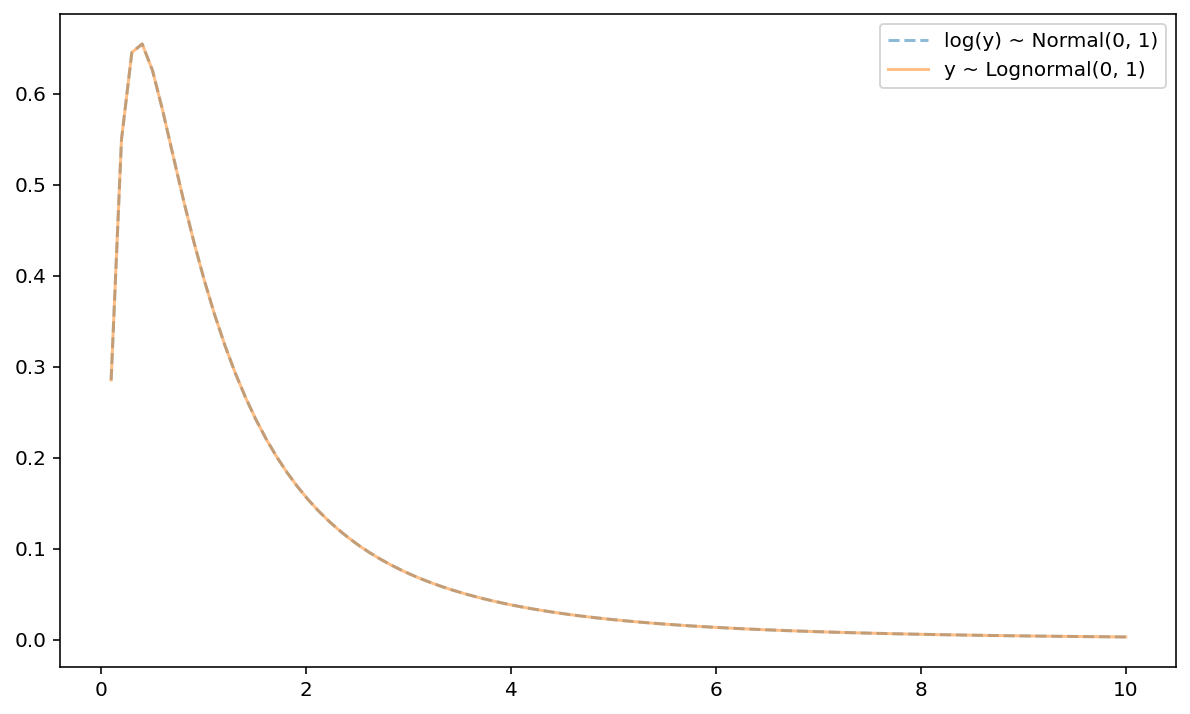

In [ ]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 6)

lognorm1 = model.named_vars["x1_exp__"]
lognorm2 = model.named_vars["x2"]

_, ax = plt.subplots(1, 1)
x = np.linspace(0.0, 10.0, 100)
ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    "--",
    alpha=0.5,
    label="log(y) ~ Normal(0, 1)",
)
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha=0.5,
    label="y ~ Lognormal(0, 1)",
)
plt.legend()

## 2.4 MCMC (Markov Chain Monte Carlo)
* 実際にPyMC3で事後分布からのサンプリングを行う前に・・・
* PyMC3の動作原理であるMCMCについて、大体のところを理解しておく。
 * 参考資料 https://www.ism.ac.jp/~shiro/papers/2017.05.slides/Iba.pdf

### 2.4.1 Monte Carlo近似
* ベイズ的モデリングで、事後分布を求めてどうするのか。
* 事後分布に関して、何らかの$\theta$の関数$f(\theta)$の期待値を計算することが、しばしばある。
$$ E_{p(\theta|X)}[f(\theta)] = \int f(\theta) p(\theta|X) d\theta$$
 * 例えば、$f(\theta)$として、モデリングで使っている尤度関数$p(x|\theta)$を持ってくると、上の式は予測分布$p(x|X)$を表すことになる。
$$ E_{p(\theta|X)}[p(x|\theta)] = \int p(x|\theta) p(\theta|X) d\theta = p(x|X)$$
* 期待値$E_{p(\theta|X)}[f(\theta)]$のこの計算を、以下の平均値で近似することを、Monte Carlo近似と呼ぶ。
$$ E_{p(\theta|X)}[f(\theta)] = \int f(\theta) p(\theta|X) d\theta \approx \frac{1}{S} \sum_{s=1}^N f(\theta_s) $$
* こういう近似計算をするとき、サンプルは独立に取ったりするが、MCMCでは独立にサンプルを取らない。
 * MCMCにおいては、次のサンプルは現在のサンプルに依存する確率分布から取られる。

### 2.4.2 Markov Chain
* マルコフ連鎖とは、確率変数の列$X_1, X_2, \ldots$で、以下を満たすもののことを言う。
$$P(X_{t+1} = x | X_t=x_t, \ldots, X_1=x_1) = P(X_{t+1}=x | X_t=x_t) $$
 * 次の値の出現確率が、直前の値だけに依存する、ということ。
 * 次の値の出現確率$P(X_{t+1}=x | X_t=x_t)$を、以下、$\pi(x_t \rightarrow x)$と書く。
* ところで、マルコフ連鎖は、以下の等式を満たす定常分布$P(x)$を持つことがある。
$$ \sum_{x^\prime} P(x^\prime) \pi( x^\prime \rightarrow x) = P(x)$$
 * いくつかの性質を満たしてはじめて、マルコフ連鎖は定常分布を持つ。 
 * 世界で一番有名な定常分布は、PageRank？


### 2.4.3 MCMCとは？
* MCMCは、定常分布が所望の分布になるようなマルコフ連鎖を作るアルゴリズム。
* 現在の$x_t$から、次の$x_{t+1}$を"賢く"作ると、こうして得られる値の列$\{x_1,\ldots,x_M\}$が、所望の分布からのサンプルになっている。
* 実際には、最初の数百個〜数千個のサンプルは捨てる。（捨てる期間を[burn-in](https://www.johndcook.com/blog/2016/01/25/mcmc-burn-in/) periodと呼ぶ。）
 * 最初の方のサンプルは、高確率な領域からのサンプルになっていない。
 * そのため、上述のモンテカルロ近似が、あまり良い近似にならない。

### 2.4.4 詳細釣り合い条件
$$ P(x) \pi (x \rightarrow x^\prime) = P(x^\prime) \pi (x^\prime \rightarrow x)$$
* 上の式は、詳細釣り合い条件、あるいは、可逆性条件と呼ばれる。
* 詳細釣り合い条件は、$\pi$で表されるマルコフ連鎖の定常分布が$P(x)$になるための、**十分条件**。
 * つまり、詳細釣り合い条件なしのMCMCもありうる（これは割愛）。


## 2.5 メトロポリス法
* メトロポリス法は、詳細釣り合い条件を満たすような$\pi$を得る一つの方法。

### 2.5.1 メトロポリス法のアルゴリズム







1.   今の$x$の次にくる値の候補$x^{new}$を、対称な提案分布$Q(x, x^{new})$に従って生成。
2.   一様乱数$0 \leq r < 1$を発生させる。
3.   $r < \frac{P(x^{new})}{P(x)}$ならば、$x$を$x^{new}$で置き換える。そうでなければ、次の値も今の値と同じ$x$にする。

* ただし、提案分布$Q$が対称とは、$Q(x, x^\prime) = Q(x^\prime, x)$が満たされることをいう。
* $\frac{P(x^{new})}{P(x)}$という比は、分布$P$の密度関数が分かっていなくても、密度関数に比例する関数が分かっていれば、計算できる。
 * 例えば、$P(\theta|X)$が分かっていなくても、$P(X|\theta)P(\theta)$が分かっていれば、計算できる。

### 2.5.2 メトロポリス法が詳細釣り合い条件を満たすことの証明

* $x$がとりうる２つの値、$\alpha$および$\gamma$を考える。
* 一般性を失うことなく、$P(\alpha) < P(\gamma)$を仮定する。
* 今の値が$\alpha$で、次の値の候補が$\gamma$であるとき、$1 < \frac{P(\gamma)}{P(\alpha)}$となり、一様乱数の値$r$が何であっても必ず$r < \frac{P(\gamma)}{P(\alpha)}$が満たされる。つまり、候補$\gamma$は$r$の値によらず採用される。よって、$\alpha$から$\gamma$へ遷移する確率$\pi(\alpha \to \gamma)$は、$Q(\alpha, \gamma)$に一致する。
* 今の値が$\gamma$で、次の値の候補が$\alpha$であるときは、$r < \frac{P(\alpha)}{P(\gamma)}$が成り立たなければ$\alpha$は採用されない。よって、$\gamma$から$\alpha$へ遷移する確率$\pi(\gamma \to \alpha)$は、$Q(\gamma, \alpha) \times \frac{P(\alpha)}{P(\gamma)}$に一致する。
* 詳細釣り合い条件において等式で結ばれている両辺のうち、今の値が$\alpha$である場合に対応するほうは、$P(\alpha)\pi(\alpha \to \gamma)$であり、これは、$P(\alpha)Q(\alpha, \gamma)$となる。
* 詳細釣り合い条件において等式で結ばれている両辺のうち、今の値が$\gamma$である場合に対応するほうは、$P(\gamma)\pi(\gamma \to \alpha)$であり、これは、$P(\gamma)Q(\gamma, \alpha) \times \frac{P(\alpha)}{P(\gamma)} = P(\alpha) Q(\gamma, \alpha)$となる。
* 提案分布$Q$は対称だったので、これら両辺は等しくなる。

* 以上の議論により、メトロポリス法で得られる$x$の列は、確率分布$P$からのサンプルの列と見なすことができる。

* メトロポリス法は、次の値の候補$x^{new}$が採用されないと、前に進まない。
* つまり、選んだ提案分布が不味くて、いくら候補をそこから生成させてもほとんどが採用されないと、いくら時間をかけても少ししかサンプルが得られない。
* 良い提案分布を選ぶことが重要である！

## 2.6 メトロポリス・ヘイスティングス法
* MH法では、非対称な提案分布も使える。
 * よって、メトロポリス法はMH法の特殊ケースだと言える。

### 2.6.1 メトロポリス・ヘイスティングス法のアルゴリズム 


1.   今の$x$の次にくる値の候補$x^{new}$を、提案分布$Q(x, x^{new})$に従って生成。
2.   一様乱数$0 \leq r < 1$を発生させる。
3.   $r < A(x,x^{new})$ならば、$x$を$x^{new}$で置き換える。そうでなければ、次の値も今の値と同じ$x$にする。ただし、$A(x,x^{new})$は以下のように定義される：

$$ A(x,x^{new}) \equiv \min \bigg(1, \frac{P(x^{new})Q(x^{new}, x)}{P(x) Q(x, x^{new})} \bigg) $$